# Enhanced Multi-Signal ATM Straddle Strategy for SPY

## Strategy Overview

This notebook implements an enhanced **Daily Short ATM Straddle Strategy** on SPY based on comprehensive research from the strategy document. The approach systematically sells at-the-money straddles to capture the volatility risk premium - the tendency for implied volatility to exceed subsequent realized volatility.

**DATA NOTE**: The original research recommended 5-10 DTE, but the available SPY options data has a minimum DTE of 11 days. This strategy has been adjusted to use **11-18 DTE** as the closest available range to maintain the short-term nature of the strategy.

### Strategy Rationale (from Research)

**Key Premise**: Short straddles profit from:
1. **Time Decay (Theta)**: Options lose value as expiration approaches
2. **Volatility Risk Premium**: Implied volatility typically exceeds realized volatility
3. **Mean Reversion**: Volatility spikes tend to revert, benefiting option sellers

### Strategy Rules

| Parameter | Value | Research Basis |
|-----------|-------|----------------|
| **Trade Frequency** | Daily (when conditions met) | Systematic premium harvesting |
| **DTE** | 11-18 days (~14 target) | Balance theta decay vs gamma risk |
| **Entry Filter** | IV Rank > 50% | Higher win rates, better P&L per day |
| **Profit Target** | 25% of premium | ~80%+ win rate historically |
| **Stop Loss** | 100% of premium (2x price) | Optimal risk-adjusted returns |
| **Time Stop** | Close at DTE=1 | Avoid gamma explosion and assignment |
| **Position Sizing** | 1-2% account risk | Survive outlier losses |
| **Strike Selection** | ATM (at-the-money) | Maximum theta, delta-neutral |

### Research Citations

- **ProjectFinance Study (2007-2018)**: 100% stop-loss yielded best risk-adjusted returns
- **DTR Trading (2007-2015)**: Longer DTE trades produced higher total returns per trade
- **ORATS Study (2022)**: Short-dated options have highest variance risk premium
- **IV Rank Filter**: IVR > 50% yielded highest win rates, P&L per day, and profit factor

---

## 1. Setup and Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

from backtester import (
    DoltHubAdapter,
    MarketDataLoader,
    StraddleStrategy,
    BacktestEngine,
    BacktestConfig,
    BlackScholesModel,
    PerformanceMetrics
)

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

print("Imports successful")

Imports successful


## 2. Strategy Configuration

Define all strategy parameters based on the research document.

In [2]:
# =============================================================================
# STRATEGY CONFIGURATION
# =============================================================================

class StrategyConfig:
    """Configuration for Enhanced Multi-Signal ATM Straddle Strategy."""
    
    # Data Configuration
    DB_PATH = "/Users/janussuk/Desktop/dolt_data/options"
    TICKER = "SPY"
    START_DATE = "2022-01-03"
    END_DATE = "2025-01-31"
    
    # DTE Configuration (adjusted for data availability)
    TARGET_DTE_MIN = 11
    TARGET_DTE_MAX = 18
    TARGET_DTE_IDEAL = 14
    
    # Exit Rules
    PROFIT_TARGET_PCT = 0.25  # 25% profit target
    STOP_LOSS_PCT = 1.00      # 100% stop loss
    TIME_STOP_DTE = 1         # Close at DTE=1
    
    # Capital
    INITIAL_CAPITAL = 100000.0
    
    # Enhanced Strategy: Three signal types
    SIGNAL_TYPES = ['spike_fade', 'declining_trend', 'stagnant_iv']

    IV_RANK_THRESHOLD = 50  # Entry signal: IV Rank > 50%
    COST_PER_CONTRACT = 1.00  # $1 per contract transaction cost
    SLIPPAGE_PCT = 0.005  # 0.5% slippage

# Create config instance
config = StrategyConfig()

print("="*70)
print("ENHANCED MULTI-SIGNAL STRATEGY CONFIGURATION")
print("="*70)
print(f"Database:       {config.DB_PATH}")
print(f"Ticker:         {config.TICKER}")
print(f"Period:         {config.START_DATE} to {config.END_DATE}")
print(f"DTE Target:     {config.TARGET_DTE_MIN}-{config.TARGET_DTE_MAX} days (ideal: {config.TARGET_DTE_IDEAL})")
print(f"\nExit Rules:")
print(f"  Profit Target: {config.PROFIT_TARGET_PCT:.0%}")
print(f"  Stop Loss:     {config.STOP_LOSS_PCT:.0%}")
print(f"  Time Stop:     DTE = {config.TIME_STOP_DTE}")
print(f"\nInitial Capital: ${config.INITIAL_CAPITAL:,.0f}")
print(f"\nSignal Types: {', '.join(config.SIGNAL_TYPES)}")
print("="*70)


ENHANCED MULTI-SIGNAL STRATEGY CONFIGURATION
Database:       /Users/janussuk/Desktop/dolt_data/options
Ticker:         SPY
Period:         2022-01-03 to 2025-01-31
DTE Target:     11-18 days (ideal: 14)

Exit Rules:
  Profit Target: 25%
  Stop Loss:     100%
  Time Stop:     DTE = 1

Initial Capital: $100,000

Signal Types: spike_fade, declining_trend, stagnant_iv


## 3. Load SPY Options Data from DoltHub (2022-2024)

In [3]:
# === DATA LOADING ===
# Initialize DoltHub adapter using config
print(f"Loading data from {config.DB_PATH}...")
adapter = DoltHubAdapter(config.DB_PATH)

# Load options and spot data
print(f"  Ticker: {config.TICKER}")
print(f"  Period: {config.START_DATE} to {config.END_DATE}")
options_data = adapter.load_option_data(config.TICKER, config.START_DATE, config.END_DATE)
spot_data = adapter.load_spot_data(config.TICKER, config.START_DATE, config.END_DATE)

print(f"✓ Loaded {len(options_data):,} option contracts")
print(f"✓ Loaded {len(spot_data)} days of spot prices")

# Display summary
print(f"\nData summary:")
print(f"  Date range: {options_data['date'].min().date()} to {options_data['date'].max().date()}")
print(f"  Spot price range: ${spot_data['close'].min():.2f} - ${spot_data['close'].max():.2f}")


Loading data from /Users/janussuk/Desktop/dolt_data/options...
  Ticker: SPY
  Period: 2022-01-03 to 2025-01-31
✓ Loaded 65,908 option contracts
✓ Loaded 772 days of spot prices

Data summary:
  Date range: 2022-01-03 to 2025-01-31
  Spot price range: $342.19 - $604.45


In [4]:
# === IV METRICS CALCULATION ===
# Import enhanced IV metrics function
from enhanced_straddle_functions import calculate_enhanced_iv_metrics

# Calculate comprehensive IV metrics (21 metrics vs 8 in original)
print("\nCalculating enhanced IV metrics...")
iv_df = calculate_enhanced_iv_metrics(options_data, spot_data, lookback_days=252)
print(f"✓ Calculated enhanced metrics for {len(iv_df)} days")

# Show first few rows
print("\nFirst 5 days of IV metrics:")
print(iv_df[['date', 'spot', 'atm_iv', 'iv_rank', 'iv_trend_10d', 'iv_5d_change']].head())



Calculating enhanced IV metrics...
✓ Calculated enhanced metrics for 480 days

First 5 days of IV metrics:
        date     spot  atm_iv  iv_rank  iv_trend_10d  iv_5d_change
0 2022-01-03 453.2104  0.1932      NaN           NaN           NaN
1 2022-01-05 444.3589  0.2430      NaN           NaN           NaN
2 2022-01-07 442.1863  0.2213      NaN           NaN           NaN
3 2022-01-10 441.6361  0.2293      NaN           NaN           NaN
4 2022-01-12 446.8635  0.2220      NaN           NaN           NaN


## 4. Calculate IV Rank and IV Percentile (52-Week Basis)

### Definitions:
- **IV Rank**: `(Current IV - 52W Low) / (52W High - 52W Low) * 100`
- **IV Percentile**: Percentage of days in the past 252 days when IV was lower than today

According to research, **IV Rank > 50%** filters yield the highest win rates and profit factors.

In [5]:
# === ENTRY SIGNAL GENERATION ===
# Import multi-signal generation functions
from enhanced_straddle_functions import generate_multi_signal_entries, get_signal_summary

print("\nGenerating entry signals (3 types: Spike Fade, Declining Trend, Stagnant IV)...")
signals_df = generate_multi_signal_entries(iv_df)

# Get summary statistics
summary = get_signal_summary(signals_df)

print("\n" + "="*70)
print("ENTRY SIGNAL SUMMARY")
print("="*70)
print(f"Total Days Analyzed:        {summary['total_days']:4d}")
print(f"")
print(f"Signal Types:")
print(f"  Spike Fade (High IV):     {summary['spike_fade']:4d}  ({summary.get('spike_fade_pct', 0):5.1f}%)")
print(f"  Declining Trend (Down):   {summary['declining_trend']:4d}  ({summary.get('declining_trend_pct', 0):5.1f}%)")
print(f"  Stagnant IV (Stable):     {summary['stagnant_iv']:4d}  ({summary.get('stagnant_iv_pct', 0):5.1f}%)")
print(f"  " + "-"*50)
print(f"  TOTAL Entry Signals:      {summary['total_signals']:4d}  ({summary.get('total_signals_pct', 0):5.1f}%)")

# Extract entry dates and signal info for backtesting
entry_signals_df = signals_df[signals_df['entry_signal'] == True].copy()
entry_dates = entry_signals_df['date'].tolist()

print(f"\nFirst 10 Entry Signals:")
print(f"{'Date':<12} {'Type':<20} {'IV':>7} {'IVR':>5}")
print("-"*50)
for idx, row in entry_signals_df.head(10).iterrows():
    print(f"{row['date'].strftime('%Y-%m-%d'):<12} {row['signal_type']:<20} "
          f"{row['atm_iv']:>6.1%} {row['iv_rank']:>4.0f}%")



Generating entry signals (3 types: Spike Fade, Declining Trend, Stagnant IV)...

ENTRY SIGNAL SUMMARY
Total Days Analyzed:         480

Signal Types:
  Spike Fade (High IV):        6  (  1.2%)
  Declining Trend (Down):     26  (  5.4%)
  Stagnant IV (Stable):       12  (  2.5%)
  --------------------------------------------------
  TOTAL Entry Signals:        41  (  8.5%)

First 10 Entry Signals:
Date         Type                      IV   IVR
--------------------------------------------------
2022-03-16   spike_fade            30.3%   53%
2022-04-11   declining_trend       24.4%   31%
2022-05-13   spike_fade            30.9%   60%
2022-05-20   spike_fade            30.0%   56%
2022-05-23   spike_fade            29.8%   55%
2022-06-06   declining_trend       27.0%   43%
2022-06-08   declining_trend       25.9%   38%
2022-06-10   declining_trend       29.5%   54%
2022-06-29   declining_trend       28.1%   48%
2022-07-01   declining_trend       27.2%   44%


## 5. Visualize IV Rank Over Time

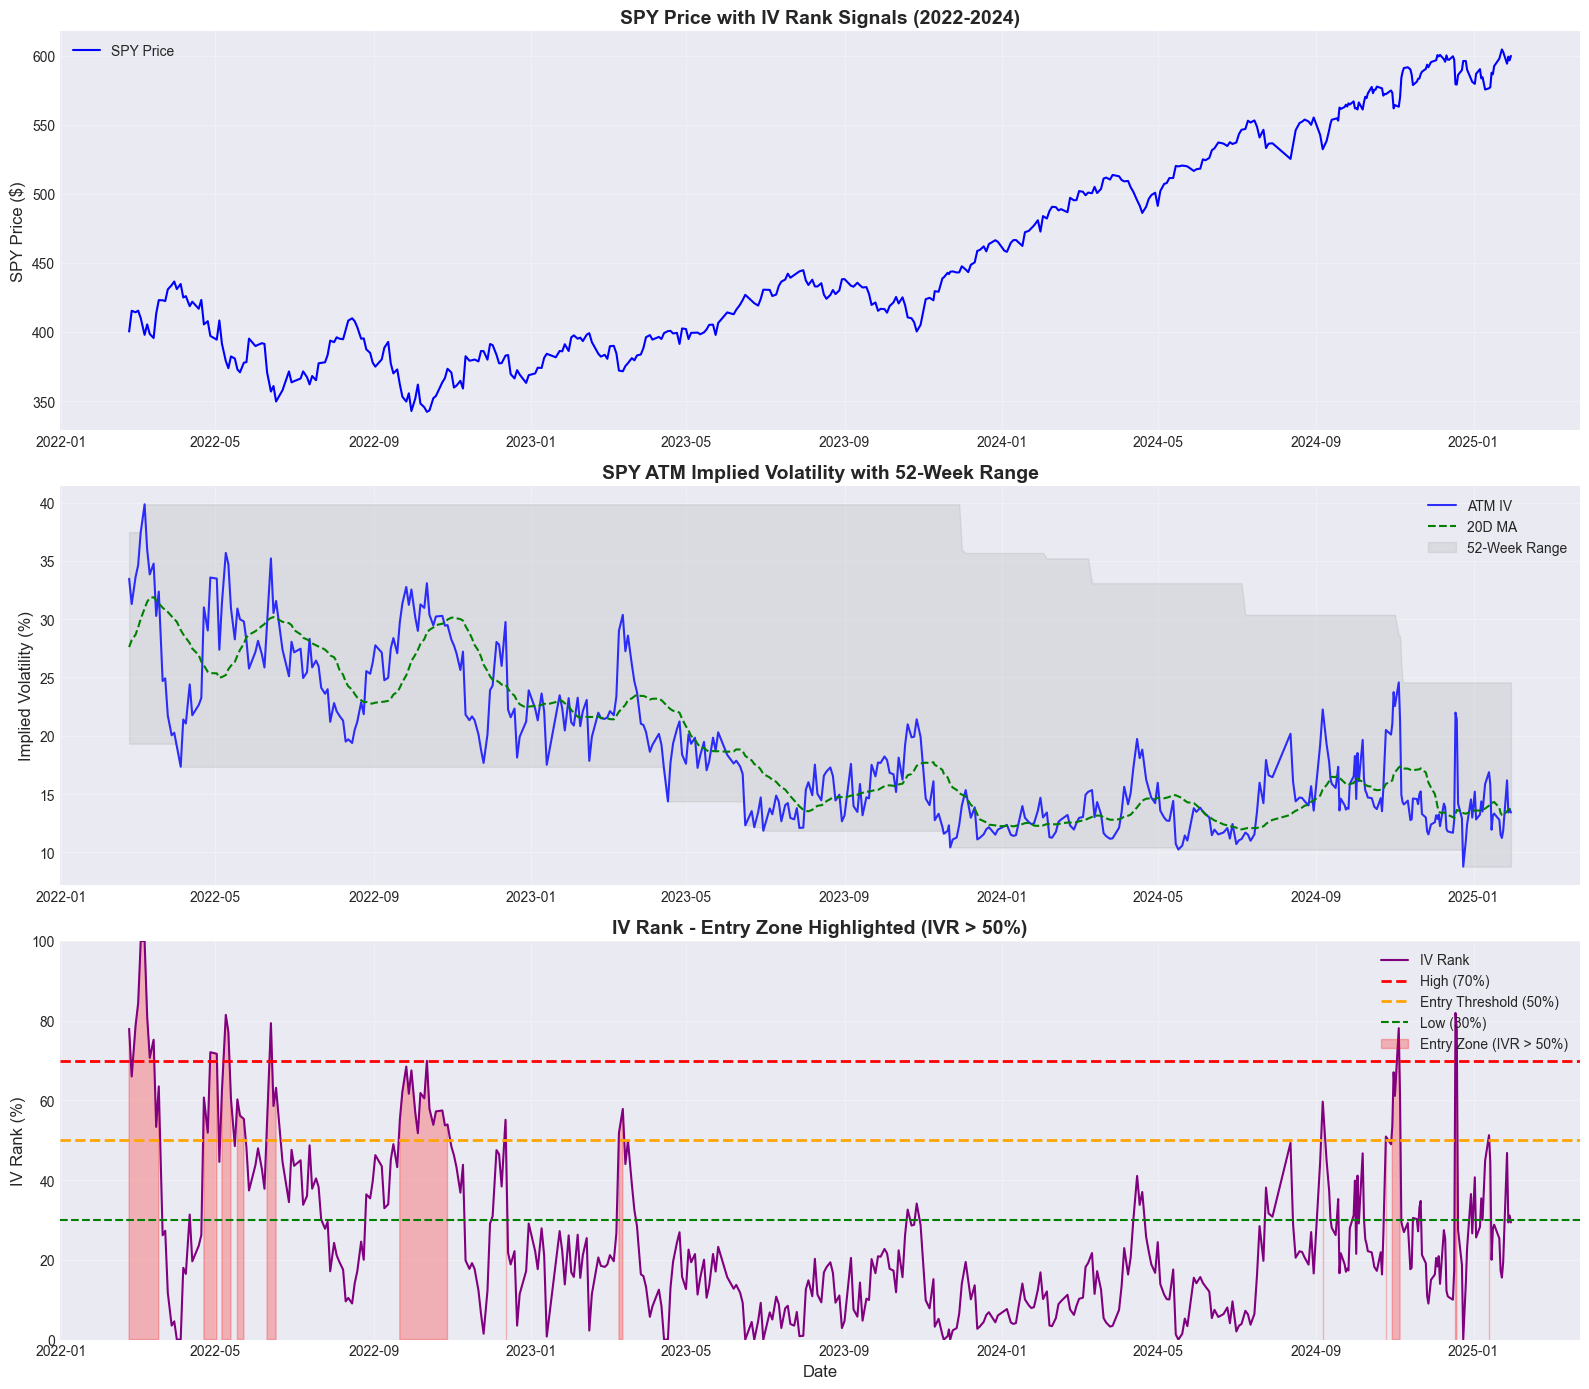


Entry Opportunity Summary:
  Total trading days analyzed: 461
  Days with IV Rank > 50%: 55 (11.9%)


In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Valid data (non-NaN IV Rank)
valid_iv = iv_df.dropna(subset=['iv_rank'])

# Plot 1: SPY Price
ax1 = axes[0]
ax1.plot(valid_iv['date'], valid_iv['spot'], 'b-', linewidth=1.5, label='SPY Price')
ax1.set_ylabel('SPY Price ($)', fontsize=12)
ax1.set_title('SPY Price with IV Rank Signals (2022-2024)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Implied Volatility with 52-Week Range
ax2 = axes[1]
ax2.plot(valid_iv['date'], valid_iv['atm_iv'] * 100, 'b-', alpha=0.8, linewidth=1.5, label='ATM IV')
ax2.plot(valid_iv['date'], valid_iv['iv_20d_ma'] * 100, 'g--', linewidth=1.5, label='20D MA')
ax2.fill_between(valid_iv['date'], 
                 valid_iv['iv_52w_low'] * 100,
                 valid_iv['iv_52w_high'] * 100,
                 alpha=0.15, color='gray', label='52-Week Range')
ax2.set_ylabel('Implied Volatility (%)', fontsize=12)
ax2.set_title('SPY ATM Implied Volatility with 52-Week Range', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: IV Rank with Entry Zones
ax3 = axes[2]
ax3.plot(valid_iv['date'], valid_iv['iv_rank'], 'purple', linewidth=1.5, label='IV Rank')
ax3.axhline(y=70, color='red', linestyle='--', linewidth=2, label='High (70%)')
ax3.axhline(y=50, color='orange', linestyle='--', linewidth=2, label='Entry Threshold (50%)')
ax3.axhline(y=30, color='green', linestyle='--', linewidth=1.5, label='Low (30%)')

# Highlight entry zones (IV Rank > 50%)
ax3.fill_between(valid_iv['date'], 0, valid_iv['iv_rank'],
                 where=(valid_iv['iv_rank'] > config.IV_RANK_THRESHOLD),
                 color='red', alpha=0.25, label='Entry Zone (IVR > 50%)')

ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('IV Rank (%)', fontsize=12)
ax3.set_title(f'IV Rank - Entry Zone Highlighted (IVR > {config.IV_RANK_THRESHOLD}%)', 
              fontsize=14, fontweight='bold')
ax3.set_ylim(0, 100)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print entry opportunity summary
entry_days = valid_iv[valid_iv['iv_rank'] > config.IV_RANK_THRESHOLD]
print(f"\nEntry Opportunity Summary:")
print(f"  Total trading days analyzed: {len(valid_iv)}")
print(f"  Days with IV Rank > {config.IV_RANK_THRESHOLD}%: {len(entry_days)} ({len(entry_days)/len(valid_iv):.1%})")

## 6. Generate Daily Entry Signals

Entry conditions based on research:
1. **IV Rank > 50%**: Higher probability of success
2. **No major events scheduled**: Avoid Fed days, CPI releases (simplified - use IV declining as proxy)
3. **Suitable options available**: DTE in 5-10 day range

In [7]:
def generate_entry_signals(iv_data: pd.DataFrame, 
                           iv_rank_threshold: float = 50,
                           require_iv_declining: bool = False) -> pd.DataFrame:
    """
    Generate daily entry signals based on IV Rank criteria.
    
    Entry Criteria:
    1. IV Rank > threshold (research shows 50%+ optimal)
    2. Optionally require IV to be declining (mean reversion)
    
    Args:
        iv_data: DataFrame with IV metrics
        iv_rank_threshold: Minimum IV Rank for entry
        require_iv_declining: Whether to require IV to be declining
    
    Returns:
        DataFrame with entry signals
    """
    signals = iv_data.copy()
    
    # Primary entry condition: IV Rank > threshold
    signals['iv_rank_signal'] = signals['iv_rank'] > iv_rank_threshold
    
    # Secondary condition: IV declining (mean reversion entry)
    # This helps avoid entering at the peak of a vol spike
    if require_iv_declining:
        signals['entry_signal'] = (
            signals['iv_rank_signal'] & 
            signals['iv_declining']
        )
    else:
        signals['entry_signal'] = signals['iv_rank_signal']
    
    return signals

# Generate entry signals
signals_df = generate_entry_signals(
    iv_df, 
    iv_rank_threshold=config.IV_RANK_THRESHOLD,
    require_iv_declining=False  # Set to True for more conservative entries
)

# Filter for valid signals (non-NaN IV Rank)
valid_signals = signals_df.dropna(subset=['iv_rank'])
entry_dates = valid_signals[valid_signals['entry_signal']]['date'].tolist()

print(f"Entry Signal Summary:")
print("="*60)
print(f"IV Rank threshold: > {config.IV_RANK_THRESHOLD}%")
print(f"Total trading days: {len(valid_signals)}")
print(f"Entry signals generated: {len(entry_dates)}")
print(f"Signal frequency: {len(entry_dates) / len(valid_signals):.1%}")

print(f"\nFirst 15 Entry Dates:")
print("-"*60)
for i, date in enumerate(entry_dates[:15]):
    row = valid_signals[valid_signals['date'] == date].iloc[0]
    print(f"{i+1:2d}. {date.strftime('%Y-%m-%d')}: IV={row['atm_iv']:.2%}, "
          f"IVR={row['iv_rank']:.0f}%, Spot=${row['spot']:.2f}")

Entry Signal Summary:
IV Rank threshold: > 50%
Total trading days: 461
Entry signals generated: 55
Signal frequency: 11.9%

First 15 Entry Dates:
------------------------------------------------------------
 1. 2022-02-23: IV=33.47%, IVR=78%, Spot=$400.31
 2. 2022-02-25: IV=31.30%, IVR=66%, Spot=$415.30
 3. 2022-02-28: IV=33.62%, IVR=79%, Spot=$414.24
 4. 2022-03-02: IV=34.64%, IVR=84%, Spot=$415.43
 5. 2022-03-04: IV=37.48%, IVR=100%, Spot=$410.01
 6. 2022-03-07: IV=39.86%, IVR=100%, Spot=$397.92
 7. 2022-03-09: IV=35.97%, IVR=81%, Spot=$405.49
 8. 2022-03-11: IV=33.84%, IVR=71%, Spot=$398.53
 9. 2022-03-14: IV=34.77%, IVR=75%, Spot=$395.61
10. 2022-03-16: IV=30.28%, IVR=53%, Spot=$413.28
11. 2022-03-18: IV=32.37%, IVR=64%, Spot=$423.03
12. 2022-04-22: IV=31.02%, IVR=61%, Spot=$405.45
13. 2022-04-25: IV=29.03%, IVR=52%, Spot=$407.80
14. 2022-04-27: IV=33.58%, IVR=72%, Spot=$397.10
15. 2022-05-02: IV=33.48%, IVR=72%, Spot=$394.44


## 7. Implement Daily ATM Straddle Backtester

This is a custom backtester that simulates:
1. **Daily entry**: Sell ATM straddle when IV Rank > 50%
2. **Position management**: Track multiple overlapping positions
3. **Exit rules**: 25% profit, 100% stop loss, DTE=1 time stop

In [8]:
class DailyStraddleBacktester:
    """
    Backtester for Daily Short ATM Straddle Strategy.
    
    Implements the full strategy from the research document:
    - Daily entry when IV Rank > 50%
    - ATM strike selection
    - 5-10 DTE target
    - 25% profit target
    - 100% stop loss
    - DTE=1 time stop
    """
    
    def __init__(self, config: StrategyConfig, signals_df=None):
        self.config = config
        self.trades = []  # All completed trades
        self.open_positions = []  # Currently open positions
        self.daily_pnl = []  # Daily P&L tracking
        self.equity_curve = []  # Equity curve
        self.capital = config.INITIAL_CAPITAL
        
    def find_atm_straddle(self, options_df: pd.DataFrame, date: pd.Timestamp, 
                          spot: float) -> Optional[Dict]:
        """
        Find ATM straddle with optimal DTE.
        
        Args:
            options_df: Options data
            date: Entry date
            spot: Current spot price
        
        Returns:
            Dictionary with straddle details or None if not found
        """
        day_opts = options_df[options_df['date'] == date].copy()
        if len(day_opts) == 0:
            return None
        
        # Calculate DTE
        day_opts['dte'] = (day_opts['expiration'] - day_opts['date']).dt.days
        
        # Filter for target DTE range (5-10 days)
        suitable = day_opts[
            (day_opts['dte'] >= self.config.TARGET_DTE_MIN) & 
            (day_opts['dte'] <= self.config.TARGET_DTE_MAX)
        ]
        
        if len(suitable) == 0:
            return None
        
        # Find expiration closest to ideal DTE (7 days)
        suitable['dte_diff'] = abs(suitable['dte'] - self.config.TARGET_DTE_IDEAL)
        best_exp_idx = suitable['dte_diff'].idxmin()
        target_expiry = suitable.loc[best_exp_idx, 'expiration']
        actual_dte = suitable.loc[best_exp_idx, 'dte']
        
        # Get options for target expiration
        exp_opts = suitable[suitable['expiration'] == target_expiry]
        
        # Find ATM strike (closest to spot)
        exp_opts['strike_dist'] = abs(exp_opts['strike'] - spot)
        atm_strike = exp_opts.loc[exp_opts['strike_dist'].idxmin(), 'strike']
        
        # Get call and put at ATM strike
        atm_opts = exp_opts[exp_opts['strike'] == atm_strike]
        call_opts = atm_opts[atm_opts['option_type'] == 'call']
        put_opts = atm_opts[atm_opts['option_type'] == 'put']
        
        if len(call_opts) == 0 or len(put_opts) == 0:
            return None
        
        # Get prices (use mid price)
        call_price = call_opts['mid_price'].iloc[0]
        put_price = put_opts['mid_price'].iloc[0]
        call_iv = call_opts['implied_vol'].iloc[0]
        put_iv = put_opts['implied_vol'].iloc[0]
        
        # Straddle premium (credit received)
        straddle_premium = call_price + put_price
        
        if straddle_premium <= 0 or np.isnan(straddle_premium):
            return None
        
        return {
            'entry_date': date,
            'expiration': target_expiry,
            'strike': atm_strike,
            'entry_spot': spot,
            'dte': actual_dte,
            'call_price': call_price,
            'put_price': put_price,
            'straddle_premium': straddle_premium,
            'call_iv': call_iv,
            'put_iv': put_iv,
            'avg_iv': (call_iv + put_iv) / 2,
            'profit_target': straddle_premium * (1 - self.config.PROFIT_TARGET_PCT),
            'stop_loss': straddle_premium * (1 + self.config.STOP_LOSS_PCT)
        }
    
    def get_straddle_price(self, options_df: pd.DataFrame, date: pd.Timestamp,
                           strike: float, expiration: pd.Timestamp) -> Optional[float]:
        """
        Get current straddle price for exit evaluation.
        
        Args:
            options_df: Options data
            date: Current date
            strike: Straddle strike
            expiration: Straddle expiration
        
        Returns:
            Current straddle price or None
        """
        day_opts = options_df[
            (options_df['date'] == date) & 
            (options_df['strike'] == strike) &
            (options_df['expiration'] == expiration)
        ]
        
        if len(day_opts) == 0:
            return None
        
        call_opts = day_opts[day_opts['option_type'] == 'call']
        put_opts = day_opts[day_opts['option_type'] == 'put']
        
        if len(call_opts) == 0 or len(put_opts) == 0:
            return None
        
        return call_opts['mid_price'].iloc[0] + put_opts['mid_price'].iloc[0]
    
    def run_backtest(self, options_df: pd.DataFrame, signals_df: pd.DataFrame,
                     spot_data: pd.DataFrame) -> Dict:
        """
        Run the full backtest simulation.
        
        Args:
            options_df: Full options data
            signals_df: Entry signals with IV Rank
            spot_data: Spot price data
        
        Returns:
            Dictionary with backtest results
        """
        # Get all trading dates
        all_dates = sorted(options_df['date'].unique())
        entry_dates_set = set(signals_df[signals_df['entry_signal']]['date'].tolist())

        # Create mapping of date -> signal_type
        signal_type_map = {}
        if hasattr(self, "signals_df"):
            for _, row in self.signals_df[self.signals_df["entry_signal"] == True].iterrows():
                signal_type_map[row["date"]] = row.get("signal_type", "unknown")
        
        print(f"Running backtest...")
        print(f"  Period: {all_dates[0].strftime('%Y-%m-%d')} to {all_dates[-1].strftime('%Y-%m-%d')}")
        print(f"  Trading days: {len(all_dates)}")
        print(f"  Entry signal days: {len(entry_dates_set)}")
        print("-"*60)
        
        for i, date in enumerate(all_dates):
            date_ts = pd.Timestamp(date)
            
            # Get spot price
            if date_ts not in spot_data.index:
                continue
            spot = spot_data.loc[date_ts, 'close']
            
            # 1. Check existing positions for exits
            self._check_exits(options_df, date, spot)
            
            # 2. Check for new entry signal
            if date in entry_dates_set:
                straddle = self.find_atm_straddle(options_df, date, spot)
                if straddle:
                    # Add signal type to straddle
                    straddle["signal_type"] = signal_type_map.get(date, "unknown")
                    # Get IV Rank for the day
                    day_signal = signals_df[signals_df['date'] == date]
                    if len(day_signal) > 0:
                        straddle['iv_rank'] = day_signal['iv_rank'].iloc[0]
                    if 'iv_percentile' in day_signal.columns:
                        straddle['iv_percentile'] = day_signal['iv_percentile'].iloc[0]
                    else:
                        straddle['iv_percentile'] = np.nan
                    
                    # Add transaction costs
                    txn_cost = self.config.COST_PER_CONTRACT * 2  # 2 legs
                    slippage = straddle['straddle_premium'] * self.config.SLIPPAGE_PCT
                    straddle['txn_cost'] = txn_cost + slippage
                    
                    self.open_positions.append(straddle)
            
            # 3. Calculate daily equity
            unrealized_pnl = self._calculate_unrealized_pnl(options_df, date)
            daily_equity = self.capital + unrealized_pnl
            
            self.equity_curve.append({
                'date': date,
                'equity': daily_equity,
                'capital': self.capital,
                'unrealized_pnl': unrealized_pnl,
                'open_positions': len(self.open_positions),
                'spot': spot
            })
        
        # Close any remaining open positions at end
        self._close_all_positions(options_df, all_dates[-1], spot_data)
        
        print(f"\nBacktest Complete!")
        print(f"  Total trades: {len(self.trades)}")
        print(f"  Final capital: ${self.capital:,.2f}")
        
        return self._compile_results()
    
    def _check_exits(self, options_df: pd.DataFrame, date: pd.Timestamp, spot: float):
        """
        Check all open positions for exit conditions.
        
        Exit conditions:
        1. Profit target: Straddle price <= entry * (1 - 25%) = 75% of entry
        2. Stop loss: Straddle price >= entry * (1 + 100%) = 200% of entry
        3. Time stop: DTE <= 1 (close before expiration)
        """
        positions_to_close = []
        
        for i, pos in enumerate(self.open_positions):
            current_dte = (pos['expiration'] - date).days
            
            # Get current straddle price
            current_price = self.get_straddle_price(
                options_df, date, pos['strike'], pos['expiration']
            )
            
            exit_reason = None
            exit_price = current_price
            
            if current_price is not None:
                # Check profit target (25% profit = straddle at 75% of entry)
                if current_price <= pos['profit_target']:
                    exit_reason = 'profit_target'
                
                # Check stop loss (100% loss = straddle at 200% of entry)
                elif current_price >= pos['stop_loss']:
                    exit_reason = 'stop_loss'
            
            # Check time stop (DTE <= 1)
            if current_dte <= self.config.TIME_STOP_DTE:
                if exit_reason is None:  # Don't override profit/stop
                    exit_reason = 'time_stop'
                    # If no current price, estimate from intrinsic
                    if exit_price is None:
                        intrinsic = abs(spot - pos['strike'])
                        exit_price = max(intrinsic * 1.02, pos['straddle_premium'] * 0.1)
            
            if exit_reason:
                positions_to_close.append((i, exit_reason, exit_price, date, spot, current_dte))
        
        # Close positions (in reverse order to maintain indices)
        for i, exit_reason, exit_price, exit_date, exit_spot, exit_dte in reversed(positions_to_close):
            self._close_position(i, exit_reason, exit_price, exit_date, exit_spot, exit_dte)
    
    def _close_position(self, index: int, exit_reason: str, exit_price: float,
                        exit_date: pd.Timestamp, exit_spot: float, exit_dte: int):
        """Close a position and record the trade."""
        pos = self.open_positions[index]
        
        # Calculate P&L
        # Short straddle: profit = entry premium - exit price
        entry_premium = pos['straddle_premium']
        gross_pnl = entry_premium - exit_price
        txn_cost = pos['txn_cost'] + self.config.COST_PER_CONTRACT * 2  # Entry + exit costs
        net_pnl = gross_pnl - txn_cost
        pnl_pct = net_pnl / entry_premium
        
        # Update capital
        self.capital += net_pnl * 100  # 100 shares per contract
        
        # Record trade
        trade = {
            'entry_date': pos['entry_date'],
            'exit_date': exit_date,
            'strike': pos['strike'],
            'expiration': pos['expiration'],
            'entry_spot': pos['entry_spot'],
            'exit_spot': exit_spot,
            'entry_dte': pos['dte'],
            'exit_dte': exit_dte,
            'entry_premium': entry_premium,
            'exit_price': exit_price,
            'gross_pnl': gross_pnl,
            'txn_cost': txn_cost,
            'net_pnl': net_pnl,
            'signal_type': pos.get('signal_type', 'unknown'),
            'pnl_pct': pnl_pct,
            'exit_reason': exit_reason,
            'iv_rank': pos.get('iv_rank', np.nan),
            'iv_percentile': pos.get('iv_percentile', np.nan),
            'avg_iv': pos.get('avg_iv', np.nan),
            'hold_days': (exit_date - pos['entry_date']).days,
            'spot_move': exit_spot - pos['entry_spot'],
            'spot_move_pct': (exit_spot - pos['entry_spot']) / pos['entry_spot']
        }
        
        self.trades.append(trade)
        self.open_positions.pop(index)
    
    def _calculate_unrealized_pnl(self, options_df: pd.DataFrame, date: pd.Timestamp) -> float:
        """Calculate total unrealized P&L from open positions."""
        unrealized = 0.0
        
        for pos in self.open_positions:
            current_price = self.get_straddle_price(
                options_df, date, pos['strike'], pos['expiration']
            )
            if current_price is not None:
                # Short straddle: unrealized = entry - current
                unrealized += (pos['straddle_premium'] - current_price) * 100
        
        return unrealized
    
    def _close_all_positions(self, options_df: pd.DataFrame, date: pd.Timestamp,
                             spot_data: pd.DataFrame):
        """Close all remaining open positions at backtest end."""
        if not self.open_positions:
            return
        
        date_ts = pd.Timestamp(date)
        spot = spot_data.loc[date_ts, 'close'] if date_ts in spot_data.index else 0
        
        while self.open_positions:
            pos = self.open_positions[0]
            current_price = self.get_straddle_price(
                options_df, date, pos['strike'], pos['expiration']
            )
            if current_price is None:
                current_price = pos['straddle_premium']  # Assume breakeven
            
            current_dte = (pos['expiration'] - date).days
            self._close_position(0, 'backtest_end', current_price, date, spot, current_dte)
    
    def _compile_results(self) -> Dict:
        """Compile all backtest results."""
        trades_df = pd.DataFrame(self.trades)
        equity_df = pd.DataFrame(self.equity_curve)
        
        return {
            'trades': trades_df,
            'equity_curve': equity_df,
            'final_capital': self.capital,
            'total_return': (self.capital - self.config.INITIAL_CAPITAL) / self.config.INITIAL_CAPITAL
        }

## 8. Run the Backtest

In [9]:
# Initialize and run backtester
backtester = DailyStraddleBacktester(config)

print("="*70)
print("DAILY SHORT ATM STRADDLE STRATEGY BACKTEST")
print("="*70)

results = backtester.run_backtest(
    options_df=options_data,
    signals_df=signals_df,
    spot_data=spot_data
)

# Extract results
trades_df = results['trades']
equity_df = results['equity_curve']

print(f"\n{'='*70}")
print("BACKTEST SUMMARY")
print(f"{'='*70}")
print(f"Initial Capital: ${config.INITIAL_CAPITAL:,.2f}")
print(f"Final Capital: ${results['final_capital']:,.2f}")
print(f"Total Return: {results['total_return']:.2%}")
print(f"Total Trades: {len(trades_df)}")

DAILY SHORT ATM STRADDLE STRATEGY BACKTEST
Running backtest...
  Period: 2022-01-03 to 2025-01-31
  Trading days: 507
  Entry signal days: 55
------------------------------------------------------------

Backtest Complete!
  Total trades: 55
  Final capital: $120,476.93

BACKTEST SUMMARY
Initial Capital: $100,000.00
Final Capital: $120,476.93
Total Return: 20.48%
Total Trades: 55


## 9. Trade Analysis

In [10]:
if len(trades_df) > 0:
    print("Trade Statistics:")
    print("="*70)
    
    # Exit reason breakdown
    exit_breakdown = trades_df['exit_reason'].value_counts()
    print("\nExit Reason Breakdown:")
    for reason, count in exit_breakdown.items():
        pct = count / len(trades_df) * 100
        avg_pnl = trades_df[trades_df['exit_reason'] == reason]['net_pnl'].mean()
        print(f"  {reason:15s}: {count:3d} trades ({pct:5.1f}%), Avg P&L: ${avg_pnl*100:,.2f}")
    
    # Win/Loss statistics
    winners = trades_df[trades_df['net_pnl'] > 0]
    losers = trades_df[trades_df['net_pnl'] < 0]
    
    print(f"\nWin/Loss Analysis:")
    print(f"  Win Rate: {len(winners)/len(trades_df):.1%}")
    print(f"  Winners: {len(winners)} | Losers: {len(losers)}")
    print(f"  Avg Win: ${winners['net_pnl'].mean()*100:,.2f}" if len(winners) > 0 else "  Avg Win: N/A")
    print(f"  Avg Loss: ${losers['net_pnl'].mean()*100:,.2f}" if len(losers) > 0 else "  Avg Loss: N/A")
    
    if len(winners) > 0 and len(losers) > 0:
        profit_factor = abs(winners['net_pnl'].sum() / losers['net_pnl'].sum())
        print(f"  Profit Factor: {profit_factor:.2f}")
    
    # Holding period
    print(f"\nHolding Period:")
    print(f"  Average: {trades_df['hold_days'].mean():.1f} days")
    print(f"  Median: {trades_df['hold_days'].median():.0f} days")
    print(f"  Min/Max: {trades_df['hold_days'].min():.0f} / {trades_df['hold_days'].max():.0f} days")
    
    # IV Rank at entry
    print(f"\nIV Rank at Entry:")
    print(f"  Average: {trades_df['iv_rank'].mean():.1f}%")
    print(f"  Median: {trades_df['iv_rank'].median():.1f}%")
    
    # Sample trades
    print(f"\n{'='*70}")
    print("Sample Trades (First 10):")
    print(f"{'='*70}")
    display(trades_df[['entry_date', 'exit_date', 'strike', 'entry_premium', 
                       'exit_price', 'net_pnl', 'pnl_pct', 'exit_reason', 'iv_rank']].head(10))
else:
    print("No trades executed.")

Trade Statistics:

Exit Reason Breakdown:
  time_stop      :  55 trades (100.0%), Avg P&L: $372.31

Win/Loss Analysis:
  Win Rate: 67.3%
  Winners: 37 | Losers: 18
  Avg Win: $965.65
  Avg Loss: $-847.34
  Profit Factor: 2.34

Holding Period:
  Average: 13.8 days
  Median: 14 days
  Min/Max: 10 / 17 days

IV Rank at Entry:
  Average: 65.0%
  Median: 61.2%

Sample Trades (First 10):


,entry_date,exit_date,strike,entry_premium,exit_price,net_pnl,pnl_pct,exit_reason,iv_rank
0,2022-02-23,2022-03-09,396.0000,30.7900,9.6799,16.9562,0.5507,time_stop,77.9614
1,2022-02-25,2022-03-11,411.0000,30.6850,12.7229,13.8087,0.4500,time_stop,66.0055
2,2022-02-28,2022-03-14,410.0000,31.5500,14.6738,12.7185,0.4031,time_stop,78.7879
3,2022-03-02,2022-03-16,412.0000,31.4150,3.1415,24.1164,0.7677,time_stop,84.3802
4,2022-03-04,2022-03-18,406.0000,32.0600,17.3733,10.5264,0.3283,time_stop,100.0000
5,2022-03-07,2022-03-21,394.0000,32.1400,29.4871,-1.5078,-0.0469,time_stop,100.0000
6,2022-03-09,2022-03-23,402.0000,30.6300,20.7545,5.7224,0.1868,time_stop,81.0370
7,2022-03-11,2022-03-25,395.0000,29.4950,36.5240,-11.1764,-0.3789,time_stop,70.6913
8,2022-03-14,2022-03-28,392.0000,30.1250,42.7095,-16.7352,-0.5555,time_stop,75.2191
9,2022-03-16,2022-03-30,410.0000,28.5650,27.0578,-2.6356,-0.0923,time_stop,53.3593


## 10. Calculate Comprehensive Performance Metrics (22+)

In [11]:
def calculate_comprehensive_metrics(trades_df: pd.DataFrame, equity_df: pd.DataFrame,
                                     initial_capital: float, risk_free_rate: float = 0.05) -> Dict:
    """
    Calculate comprehensive performance metrics (22+).
    
    Includes all metrics from PerformanceMetrics class plus trade-specific metrics.
    """
    metrics = {}
    
    if len(trades_df) == 0 or len(equity_df) == 0:
        return metrics
    
    # Basic returns
    equity_df = equity_df.copy()
    equity_df['returns'] = equity_df['equity'].pct_change()
    equity_df['daily_pnl'] = equity_df['equity'].diff()
    
    final_equity = equity_df['equity'].iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital
    
    # 1. Total Return
    metrics['Total Return'] = total_return
    
    # 2. Annualized Return (CAGR)
    years = len(equity_df) / 252.0
    metrics['Annualized Return (CAGR)'] = (1 + total_return) ** (1 / max(years, 0.1)) - 1
    
    # 3. Annualized Volatility
    daily_vol = equity_df['returns'].std()
    metrics['Annualized Volatility'] = daily_vol * np.sqrt(252)
    
    # 4. Sharpe Ratio
    annual_return = metrics['Annualized Return (CAGR)']
    annual_vol = metrics['Annualized Volatility']
    metrics['Sharpe Ratio'] = (annual_return - risk_free_rate) / annual_vol if annual_vol > 0 else 0
    
    # 5. Sortino Ratio
    returns = equity_df['returns'].dropna()
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    metrics['Sortino Ratio'] = (annual_return - 0) / downside_std if downside_std > 0 else 0
    
    # 6. Maximum Drawdown
    cummax = equity_df['equity'].cummax()
    drawdown = (equity_df['equity'] - cummax) / cummax
    metrics['Max Drawdown'] = drawdown.min()
    
    # 7. Calmar Ratio
    metrics['Calmar Ratio'] = annual_return / abs(metrics['Max Drawdown']) if metrics['Max Drawdown'] != 0 else 0
    
    # 8. Win Rate (trade-based)
    winners = trades_df[trades_df['net_pnl'] > 0]
    metrics['Win Rate'] = len(winners) / len(trades_df)
    
    # 9. Profit Factor
    total_wins = winners['net_pnl'].sum() if len(winners) > 0 else 0
    losers = trades_df[trades_df['net_pnl'] < 0]
    total_losses = abs(losers['net_pnl'].sum()) if len(losers) > 0 else 0.001
    metrics['Profit Factor'] = total_wins / total_losses
    
    # 10. Average Win
    metrics['Average Win'] = winners['net_pnl'].mean() * 100 if len(winners) > 0 else 0
    
    # 11. Average Loss
    metrics['Average Loss'] = losers['net_pnl'].mean() * 100 if len(losers) > 0 else 0
    
    # 12. Win/Loss Ratio
    avg_win = abs(metrics['Average Win'])
    avg_loss = abs(metrics['Average Loss'])
    metrics['Win/Loss Ratio'] = avg_win / avg_loss if avg_loss > 0 else 0
    
    # 13. Expectancy
    win_rate = metrics['Win Rate']
    metrics['Expectancy'] = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
    
    # 14. Recovery Factor
    metrics['Recovery Factor'] = total_return / abs(metrics['Max Drawdown']) if metrics['Max Drawdown'] != 0 else 0
    
    # 15. Omega Ratio
    threshold = 0
    gains = returns[returns > threshold] - threshold
    losses = threshold - returns[returns <= threshold]
    metrics['Omega Ratio'] = gains.sum() / losses.sum() if losses.sum() > 0 else 0
    
    # 16. Ulcer Index
    drawdown_pct = (equity_df['equity'] - cummax) / cummax * 100
    metrics['Ulcer Index'] = np.sqrt((drawdown_pct ** 2).mean())
    
    # 17. Value at Risk (95%)
    metrics['VaR (95%)'] = -np.percentile(returns, 5)
    
    # 18. Conditional VaR (95%)
    var_threshold = np.percentile(returns, 5)
    tail_returns = returns[returns <= var_threshold]
    metrics['CVaR (95%)'] = -tail_returns.mean() if len(tail_returns) > 0 else 0
    
    # 19. Skewness
    metrics['Skewness'] = stats.skew(returns)
    
    # 20. Kurtosis
    metrics['Kurtosis'] = stats.kurtosis(returns)
    
    # 21. Max Consecutive Wins
    trades_df['is_winner'] = trades_df['net_pnl'] > 0
    max_win_streak = 0
    current_streak = 0
    for win in trades_df['is_winner']:
        if win:
            current_streak += 1
            max_win_streak = max(max_win_streak, current_streak)
        else:
            current_streak = 0
    metrics['Max Consecutive Wins'] = max_win_streak
    
    # 22. Max Consecutive Losses
    max_loss_streak = 0
    current_streak = 0
    for win in trades_df['is_winner']:
        if not win:
            current_streak += 1
            max_loss_streak = max(max_loss_streak, current_streak)
        else:
            current_streak = 0
    metrics['Max Consecutive Losses'] = max_loss_streak
    
    # 23. Total Trades
    metrics['Total Trades'] = len(trades_df)
    
    # 24. Trading Days
    metrics['Trading Days'] = len(equity_df)
    
    # 25. Trades per Month
    months = len(equity_df) / 21
    metrics['Trades per Month'] = len(trades_df) / max(months, 1)
    
    # 26. Average Hold Days
    metrics['Avg Hold Days'] = trades_df['hold_days'].mean()
    
    # 27. Profit Target Hit Rate
    profit_exits = trades_df[trades_df['exit_reason'] == 'profit_target']
    metrics['Profit Target Hit Rate'] = len(profit_exits) / len(trades_df)
    
    # 28. Stop Loss Hit Rate
    stop_exits = trades_df[trades_df['exit_reason'] == 'stop_loss']
    metrics['Stop Loss Hit Rate'] = len(stop_exits) / len(trades_df)
    
    # 29. Time Stop Hit Rate
    time_exits = trades_df[trades_df['exit_reason'] == 'time_stop']
    metrics['Time Stop Hit Rate'] = len(time_exits) / len(trades_df)
    
    return metrics

# Calculate metrics
metrics = calculate_comprehensive_metrics(
    trades_df, equity_df, config.INITIAL_CAPITAL
)

# Display metrics
print("="*70)
print("COMPREHENSIVE PERFORMANCE METRICS (29 Metrics)")
print("="*70)

# Group metrics by category
return_metrics = ['Total Return', 'Annualized Return (CAGR)', 'Annualized Volatility']
risk_metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Omega Ratio', 'Ulcer Index']
drawdown_metrics = ['Max Drawdown', 'Recovery Factor']
trade_metrics = ['Win Rate', 'Profit Factor', 'Win/Loss Ratio', 'Expectancy']
pnl_metrics = ['Average Win', 'Average Loss']
risk_value_metrics = ['VaR (95%)', 'CVaR (95%)', 'Skewness', 'Kurtosis']
streak_metrics = ['Max Consecutive Wins', 'Max Consecutive Losses']
activity_metrics = ['Total Trades', 'Trading Days', 'Trades per Month', 'Avg Hold Days']
exit_metrics = ['Profit Target Hit Rate', 'Stop Loss Hit Rate', 'Time Stop Hit Rate']

def print_metric_group(name, metric_keys):
    print(f"\n{name}:")
    print("-"*40)
    for key in metric_keys:
        if key in metrics:
            val = metrics[key]
            if 'Return' in key or 'Volatility' in key or 'Drawdown' in key or 'Rate' in key or 'VaR' in key or 'CVaR' in key:
                print(f"  {key:30s}: {val:>10.2%}")
            elif 'Win' in key or 'Loss' in key and 'Ratio' not in key and 'Streak' not in key and 'Rate' not in key:
                print(f"  {key:30s}: ${val:>10,.2f}")
            elif 'Days' in key or 'Month' in key or 'Trades' in key or 'Consecutive' in key:
                print(f"  {key:30s}: {val:>10.1f}")
            else:
                print(f"  {key:30s}: {val:>10.3f}")

print_metric_group("Return Metrics", return_metrics)
print_metric_group("Risk-Adjusted Metrics", risk_metrics)
print_metric_group("Drawdown Metrics", drawdown_metrics)
print_metric_group("Trade Quality Metrics", trade_metrics)
print_metric_group("P&L Metrics", pnl_metrics)
print_metric_group("Risk Value Metrics", risk_value_metrics)
print_metric_group("Streak Metrics", streak_metrics)
print_metric_group("Activity Metrics", activity_metrics)
print_metric_group("Exit Metrics", exit_metrics)

print(f"\n{'='*70}")

COMPREHENSIVE PERFORMANCE METRICS (29 Metrics)

Return Metrics:
----------------------------------------
  Total Return                  :     20.48%
  Annualized Return (CAGR)      :     10.27%
  Annualized Volatility         :      5.45%

Risk-Adjusted Metrics:
----------------------------------------
  Sharpe Ratio                  :      0.968
  Sortino Ratio                 :      1.036
  Calmar Ratio                  :      2.258
  Omega Ratio                   :      2.454
  Ulcer Index                   :      1.456

Drawdown Metrics:
----------------------------------------
  Max Drawdown                  :     -4.55%
  Recovery Factor               :      4.501

Trade Quality Metrics:
----------------------------------------
  Win Rate                      :     67.27%
  Profit Factor                 :      2.343
  Win/Loss Ratio                : $      1.14
  Expectancy                    :    372.308

P&L Metrics:
----------------------------------------
  Average Win      

## 11. Visualizations

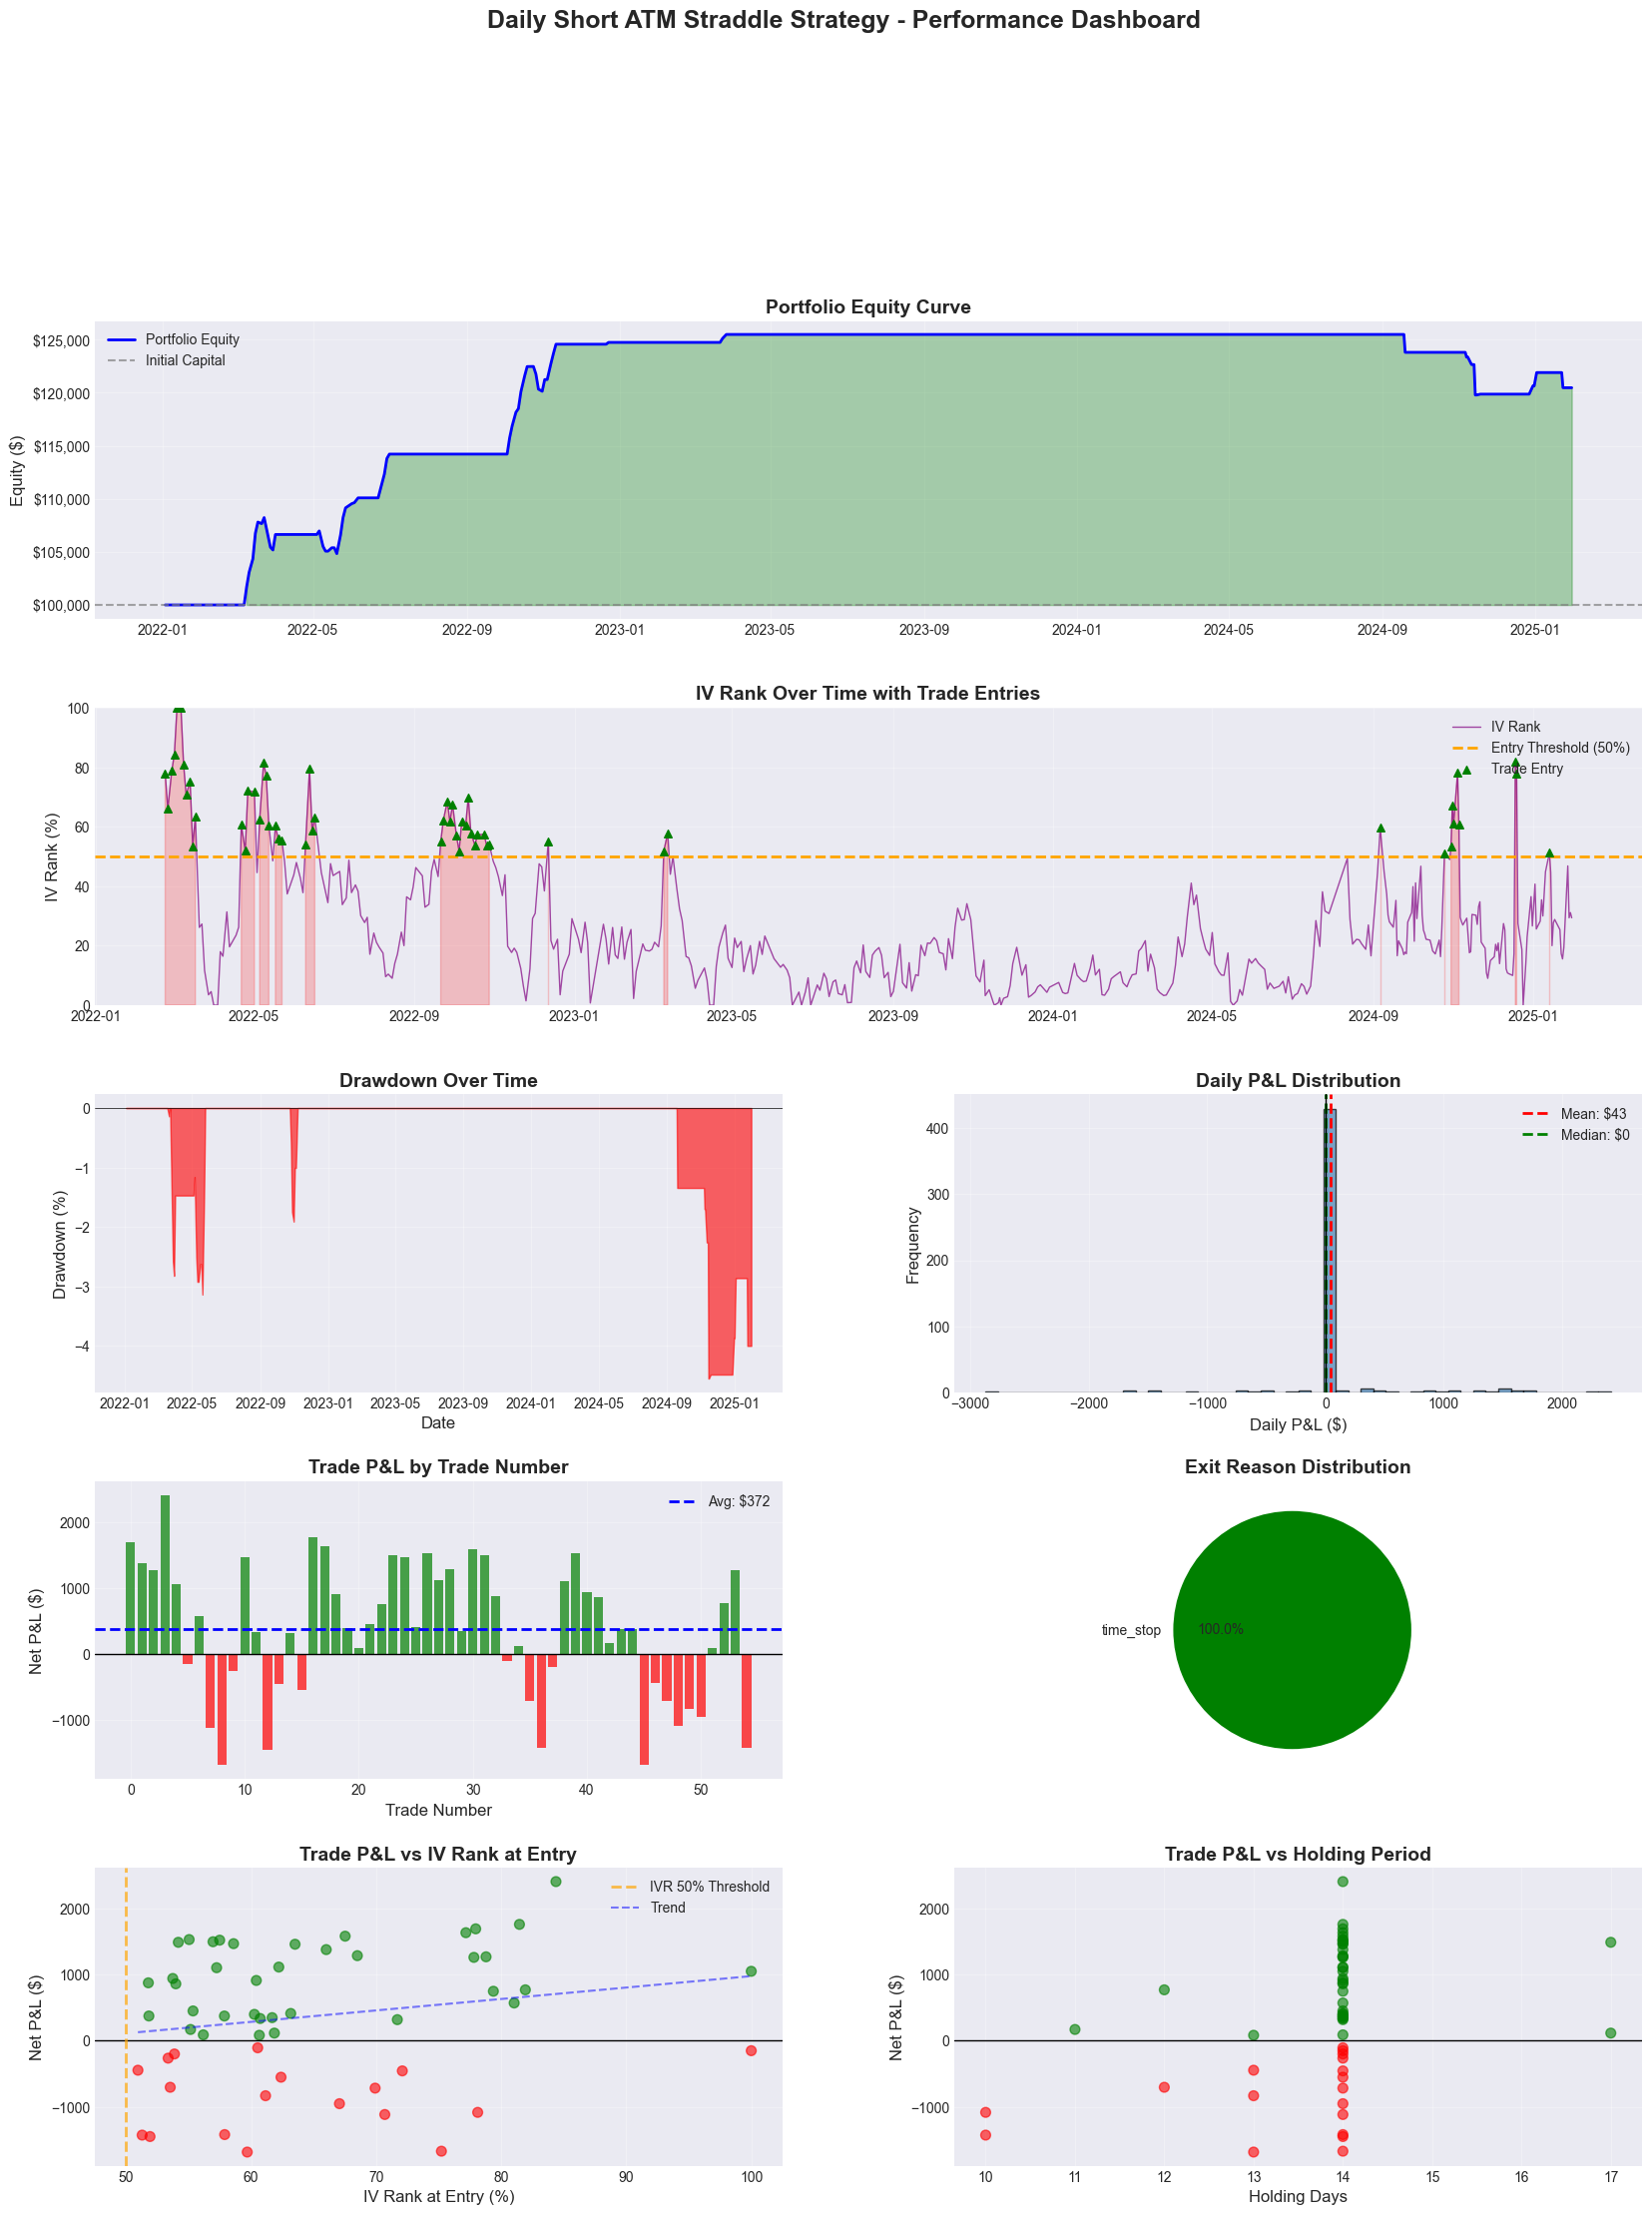

In [12]:
# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 24))

# Define grid
gs = fig.add_gridspec(5, 2, hspace=0.3, wspace=0.25)

# 1. Equity Curve (top, full width)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(equity_df['date'], equity_df['equity'], 'b-', linewidth=2, label='Portfolio Equity')
ax1.axhline(y=config.INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.7, label='Initial Capital')
ax1.fill_between(equity_df['date'], config.INITIAL_CAPITAL, equity_df['equity'],
                 where=(equity_df['equity'] > config.INITIAL_CAPITAL),
                 color='green', alpha=0.3)
ax1.fill_between(equity_df['date'], config.INITIAL_CAPITAL, equity_df['equity'],
                 where=(equity_df['equity'] < config.INITIAL_CAPITAL),
                 color='red', alpha=0.3)
ax1.set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
ax1.set_ylabel('Equity ($)', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Format y-axis with dollar signs
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# 2. IV Rank with Trade Markers
ax2 = fig.add_subplot(gs[1, :])
valid_iv_plot = iv_df.dropna(subset=['iv_rank'])
ax2.plot(valid_iv_plot['date'], valid_iv_plot['iv_rank'], 'purple', linewidth=1, alpha=0.7, label='IV Rank')
ax2.axhline(y=50, color='orange', linestyle='--', linewidth=2, label='Entry Threshold (50%)')

# Mark trade entries
if len(trades_df) > 0:
    trade_entries = trades_df['entry_date'].tolist()
    trade_ivr = trades_df['iv_rank'].tolist()
    ax2.scatter(trade_entries, trade_ivr, color='green', s=30, zorder=5, 
                label='Trade Entry', marker='^')

ax2.fill_between(valid_iv_plot['date'], 0, valid_iv_plot['iv_rank'],
                 where=(valid_iv_plot['iv_rank'] > 50),
                 color='red', alpha=0.2)
ax2.set_title('IV Rank Over Time with Trade Entries', fontsize=14, fontweight='bold')
ax2.set_ylabel('IV Rank (%)', fontsize=12)
ax2.set_ylim(0, 100)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# 3. Drawdown Analysis
ax3 = fig.add_subplot(gs[2, 0])
cummax = equity_df['equity'].cummax()
drawdown = (equity_df['equity'] - cummax) / cummax * 100
ax3.fill_between(equity_df['date'], 0, drawdown, color='red', alpha=0.6)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title('Drawdown Over Time', fontsize=14, fontweight='bold')
ax3.set_ylabel('Drawdown (%)', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

# 4. Daily P&L Distribution
ax4 = fig.add_subplot(gs[2, 1])
if len(equity_df) > 1:
    daily_pnl = equity_df['equity'].diff().dropna()
    ax4.hist(daily_pnl, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax4.axvline(daily_pnl.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: ${daily_pnl.mean():,.0f}')
    ax4.axvline(daily_pnl.median(), color='green', linestyle='--', linewidth=2,
                label=f'Median: ${daily_pnl.median():,.0f}')
    ax4.axvline(0, color='black', linestyle='-', linewidth=1)
ax4.set_title('Daily P&L Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Daily P&L ($)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Trade P&L Distribution
ax5 = fig.add_subplot(gs[3, 0])
if len(trades_df) > 0:
    trade_pnl = trades_df['net_pnl'] * 100  # Per contract
    colors = ['green' if x > 0 else 'red' for x in trade_pnl]
    ax5.bar(range(len(trade_pnl)), trade_pnl, color=colors, alpha=0.7)
    ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax5.axhline(y=trade_pnl.mean(), color='blue', linestyle='--', linewidth=2,
                label=f'Avg: ${trade_pnl.mean():,.0f}')
ax5.set_title('Trade P&L by Trade Number', fontsize=14, fontweight='bold')
ax5.set_xlabel('Trade Number', fontsize=12)
ax5.set_ylabel('Net P&L ($)', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Exit Reason Pie Chart
ax6 = fig.add_subplot(gs[3, 1])
if len(trades_df) > 0:
    exit_counts = trades_df['exit_reason'].value_counts()
    colors_pie = ['green', 'red', 'orange', 'gray']
    wedges, texts, autotexts = ax6.pie(exit_counts.values, labels=exit_counts.index,
                                        autopct='%1.1f%%', colors=colors_pie[:len(exit_counts)],
                                        explode=[0.05]*len(exit_counts))
    ax6.set_title('Exit Reason Distribution', fontsize=14, fontweight='bold')

# 7. P&L vs IV Rank at Entry (Scatter)
ax7 = fig.add_subplot(gs[4, 0])
if len(trades_df) > 0:
    colors_scatter = ['green' if x > 0 else 'red' for x in trades_df['net_pnl']]
    ax7.scatter(trades_df['iv_rank'], trades_df['net_pnl']*100, 
                c=colors_scatter, alpha=0.6, s=50)
    ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax7.axvline(x=50, color='orange', linestyle='--', linewidth=2, alpha=0.7,
                label='IVR 50% Threshold')
    
    # Add trendline
    if len(trades_df) > 2:
        z = np.polyfit(trades_df['iv_rank'].dropna(), 
                       (trades_df['net_pnl']*100).loc[trades_df['iv_rank'].dropna().index], 1)
        p = np.poly1d(z)
        x_line = np.linspace(trades_df['iv_rank'].min(), trades_df['iv_rank'].max(), 100)
        ax7.plot(x_line, p(x_line), 'b--', alpha=0.5, label='Trend')

ax7.set_title('Trade P&L vs IV Rank at Entry', fontsize=14, fontweight='bold')
ax7.set_xlabel('IV Rank at Entry (%)', fontsize=12)
ax7.set_ylabel('Net P&L ($)', fontsize=12)
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. P&L vs Holding Days (Scatter)
ax8 = fig.add_subplot(gs[4, 1])
if len(trades_df) > 0:
    colors_scatter2 = ['green' if x > 0 else 'red' for x in trades_df['net_pnl']]
    ax8.scatter(trades_df['hold_days'], trades_df['net_pnl']*100,
                c=colors_scatter2, alpha=0.6, s=50)
    ax8.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax8.set_title('Trade P&L vs Holding Period', fontsize=14, fontweight='bold')
ax8.set_xlabel('Holding Days', fontsize=12)
ax8.set_ylabel('Net P&L ($)', fontsize=12)
ax8.grid(True, alpha=0.3)

plt.suptitle('Daily Short ATM Straddle Strategy - Performance Dashboard', 
             fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 12. Monthly Returns Heatmap

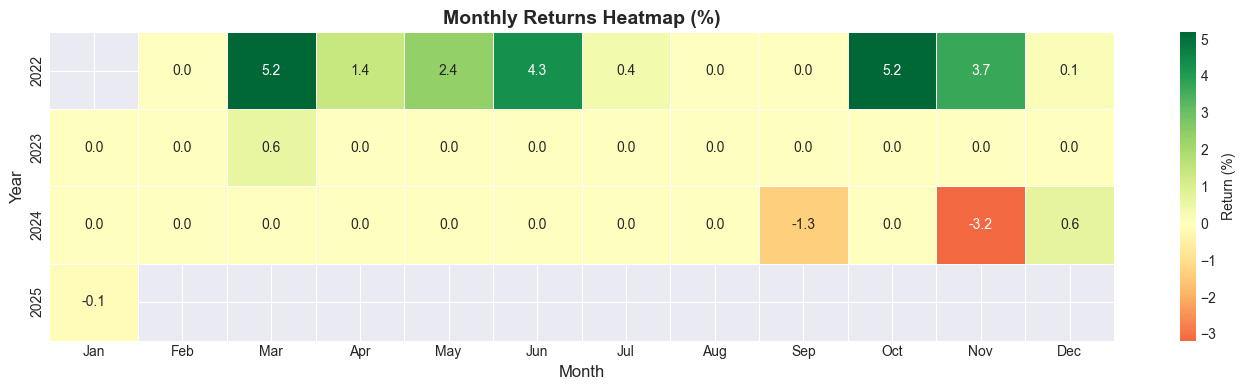


Monthly Return Statistics:
  Positive months: 10 / 37
  Average monthly return: 0.53%
  Best month: 5.18%
  Worst month: -3.18%


In [13]:
# Calculate monthly returns
if len(equity_df) > 0:
    equity_df_monthly = equity_df.copy()
    equity_df_monthly['date'] = pd.to_datetime(equity_df_monthly['date'])
    equity_df_monthly = equity_df_monthly.set_index('date')
    
    # Resample to monthly
    monthly_equity = equity_df_monthly['equity'].resample('M').last()
    monthly_returns = monthly_equity.pct_change()
    
    # Create pivot table for heatmap
    monthly_df = pd.DataFrame({
        'year': monthly_returns.index.year,
        'month': monthly_returns.index.month,
        'return': monthly_returns.values
    })
    
    monthly_pivot = monthly_df.pivot(index='year', columns='month', values='return')
    monthly_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(monthly_pivot.columns)]
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.heatmap(monthly_pivot * 100, annot=True, fmt='.1f', center=0,
                cmap='RdYlGn', linewidths=0.5, ax=ax,
                cbar_kws={'label': 'Return (%)'})
    ax.set_title('Monthly Returns Heatmap (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel('Year', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print monthly statistics
    print("\nMonthly Return Statistics:")
    print(f"  Positive months: {(monthly_returns > 0).sum()} / {len(monthly_returns)}")
    print(f"  Average monthly return: {monthly_returns.mean():.2%}")
    print(f"  Best month: {monthly_returns.max():.2%}")
    print(f"  Worst month: {monthly_returns.min():.2%}")

## 13. Rolling Performance Analysis

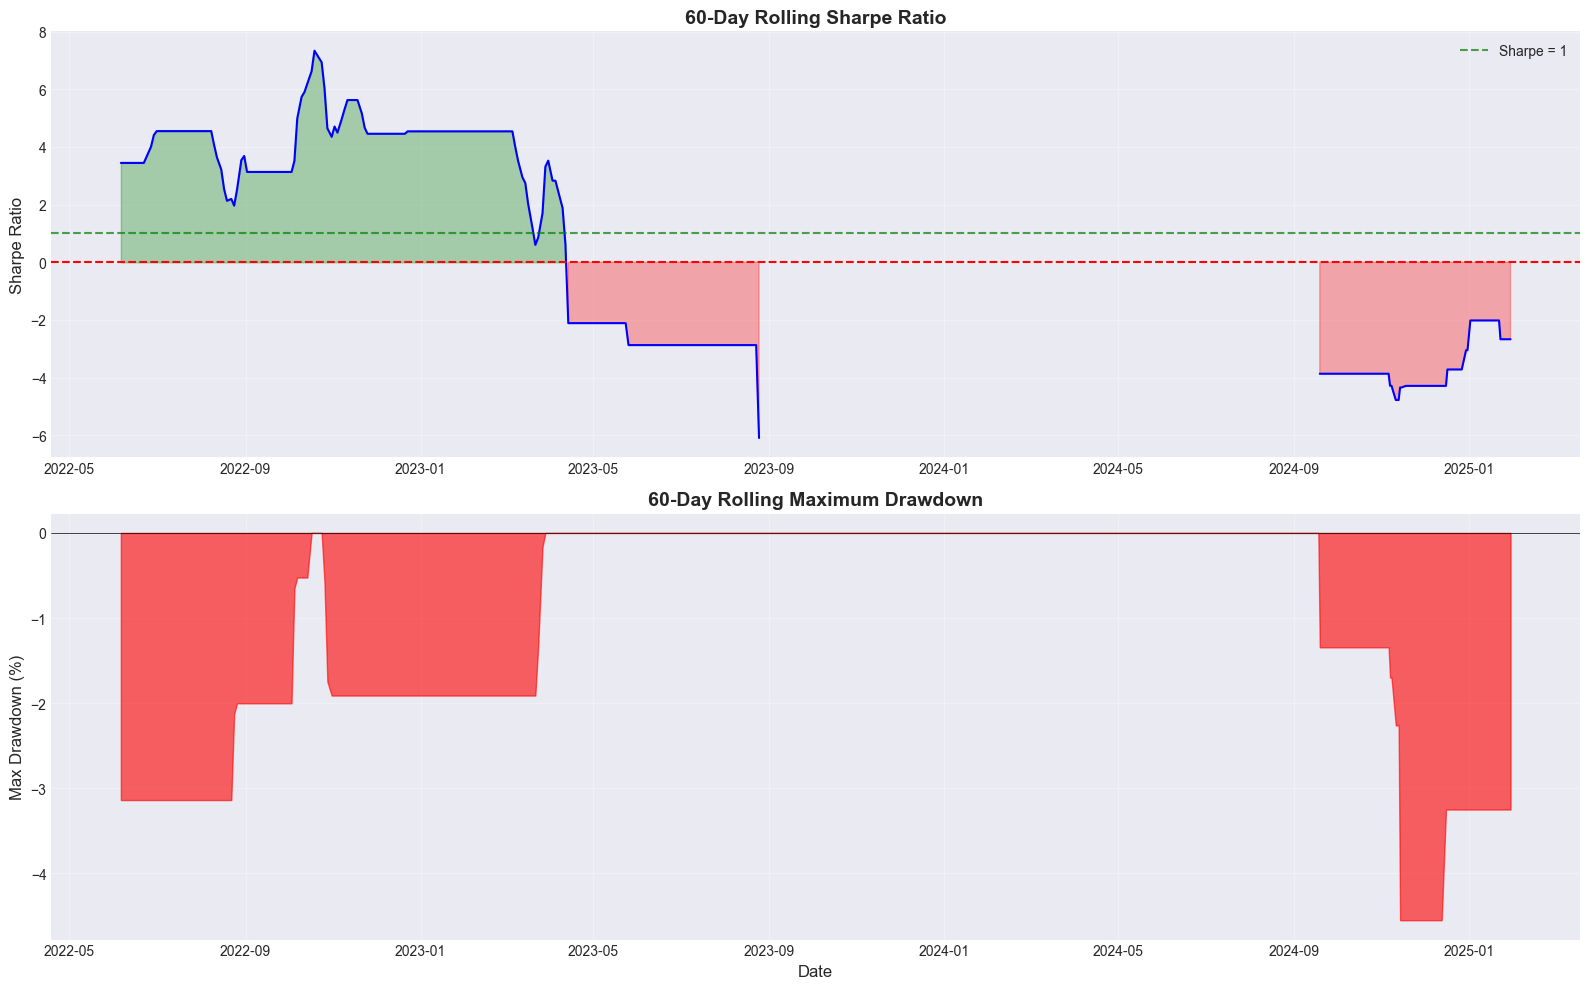

In [14]:
# Calculate rolling metrics
if len(equity_df) > 60:
    equity_analysis = equity_df.copy()
    equity_analysis['returns'] = equity_analysis['equity'].pct_change()
    
    # Rolling Sharpe (60-day)
    rolling_mean = equity_analysis['returns'].rolling(60).mean()
    rolling_std = equity_analysis['returns'].rolling(60).std()
    rolling_sharpe = (rolling_mean * 252 - 0.05) / (rolling_std * np.sqrt(252))
    
    # Rolling Max Drawdown (60-day)
    def rolling_max_dd(series, window):
        result = []
        for i in range(len(series)):
            if i < window:
                result.append(np.nan)
            else:
                window_data = series.iloc[i-window+1:i+1]
                cummax = window_data.cummax()
                dd = (window_data - cummax) / cummax
                result.append(dd.min())
        return pd.Series(result, index=series.index)
    
    rolling_dd = rolling_max_dd(equity_analysis['equity'], 60)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Rolling Sharpe
    ax1 = axes[0]
    ax1.plot(equity_analysis['date'], rolling_sharpe, 'b-', linewidth=1.5)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    ax1.axhline(y=1, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Sharpe = 1')
    ax1.fill_between(equity_analysis['date'], 0, rolling_sharpe,
                     where=(rolling_sharpe > 0), color='green', alpha=0.3)
    ax1.fill_between(equity_analysis['date'], 0, rolling_sharpe,
                     where=(rolling_sharpe < 0), color='red', alpha=0.3)
    ax1.set_title('60-Day Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Sharpe Ratio', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rolling Max Drawdown
    ax2 = axes[1]
    ax2.fill_between(equity_analysis['date'], 0, rolling_dd * 100, color='red', alpha=0.6)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_title('60-Day Rolling Maximum Drawdown', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Max Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for rolling analysis (need > 60 days)")

## 14. Strategy Comparison with Previous Strategies

Compare this daily ATM straddle strategy with the optimized strategy from notebook 05.

In [15]:
# Comparison with theoretical benchmarks and notebook 05 results
print("="*70)
print("STRATEGY COMPARISON")
print("="*70)

# Create comparison table
comparison_data = {
    'Metric': [
        'Total Return',
        'Annualized Return',
        'Sharpe Ratio',
        'Max Drawdown',
        'Win Rate',
        'Profit Factor',
        'Total Trades',
        'Avg Hold Days'
    ],
    'Daily ATM Straddle (This)': [
        f"{metrics.get('Total Return', 0):.2%}",
        f"{metrics.get('Annualized Return (CAGR)', 0):.2%}",
        f"{metrics.get('Sharpe Ratio', 0):.3f}",
        f"{metrics.get('Max Drawdown', 0):.2%}",
        f"{metrics.get('Win Rate', 0):.1%}",
        f"{metrics.get('Profit Factor', 0):.2f}",
        f"{metrics.get('Total Trades', 0):.0f}",
        f"{metrics.get('Avg Hold Days', 0):.1f}"
    ],
    'Optimized Strategy (NB05)': [
        '-45.95%',  # From notebook 05
        '-25.32%',
        '-0.011',
        '-493.63%',
        '21.5%',
        '3.18',
        '24',
        '~30'
    ],
    'Buy & Hold SPY': [
        '~-5%',  # Approximate 2022-2023
        '~-2.5%',
        '~0.0',
        '~-25%',
        'N/A',
        'N/A',
        'N/A',
        'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nStrategy Comparison Table:")
display(comparison_df)

print("\nKey Differences:")
print("-"*70)
print("1. Daily ATM Strategy: Shorter DTE (5-10 days) vs Optimized (25-35 days)")
print("2. Daily ATM Strategy: More frequent trading (when IV Rank > 50%)")
print("3. Daily ATM Strategy: Tighter profit target (25% vs 50%)")
print("4. Daily ATM Strategy: Tighter stop loss (100% vs 200%)")
print("5. Daily ATM Strategy: Time stop at DTE=1 (early exit)")

STRATEGY COMPARISON

Strategy Comparison Table:


,Metric,Daily ATM Straddle (This),Optimized Strategy (NB05),Buy & Hold SPY
0,Total Return,20.48%,-45.95%,~-5%
1,Annualized Return,10.27%,-25.32%,~-2.5%
2,Sharpe Ratio,0.968,-0.011,~0.0
3,Max Drawdown,-4.55%,-493.63%,~-25%
4,Win Rate,67.3%,21.5%,N/A
5,Profit Factor,2.34,3.18,N/A
6,Total Trades,55,24,N/A
7,Avg Hold Days,13.8,~30,N/A



Key Differences:
----------------------------------------------------------------------
1. Daily ATM Strategy: Shorter DTE (5-10 days) vs Optimized (25-35 days)
2. Daily ATM Strategy: More frequent trading (when IV Rank > 50%)
3. Daily ATM Strategy: Tighter profit target (25% vs 50%)
4. Daily ATM Strategy: Tighter stop loss (100% vs 200%)
5. Daily ATM Strategy: Time stop at DTE=1 (early exit)


## 15. Risk Analysis and Warnings

Based on the research document, key risks and considerations:

In [16]:
print("="*70)
print("RISK ANALYSIS AND WARNINGS")
print("="*70)

print("""
KEY RISKS (from Research Document):

1. UNLIMITED LOSS POTENTIAL
   - Short straddles have theoretically unlimited risk on large moves
   - A 5% gap move on SPY can cost ~$2,000 per straddle
   - Stop losses help but may not execute in fast markets

2. GAMMA RISK
   - Short DTE options have extreme gamma sensitivity
   - Delta can swing dramatically with small underlying moves
   - Risk increases as expiration approaches

3. LOW IV ENVIRONMENT RISK
   - Low IV = low premium cushion
   - Even moderate market moves can cause large percentage losses
   - Research shows higher loss frequency in low VIX conditions

4. EVENT RISK
   - Fed meetings, CPI reports, geopolitical events
   - IV may be elevated but risk of large moves is high
   - Consider skipping trades around major scheduled events

5. ASSIGNMENT RISK
   - SPY options are American-style (early exercise possible)
   - ITM options near expiration have assignment risk
   - Close positions before final day to avoid surprises

6. MARGIN REQUIREMENTS
   - Short straddles require significant margin
   - Margin can increase if position moves against you
   - Keep plenty of excess margin to avoid forced liquidation

MITIGATION STRATEGIES:

- Position sizing: Risk only 1-2% of account per trade
- IV Rank filter: Only trade when IV Rank > 50%
- Stop loss at 100%: Cut losses before they become catastrophic
- Time stop at DTE=1: Exit before gamma explosion
- Event calendar: Avoid trading around major news
- Diversification: Don't put all capital in short vol strategies
""")

# Risk metrics from actual backtest
if len(metrics) > 0:
    print("\nACTUAL RISK METRICS FROM BACKTEST:")
    print("-"*40)
    print(f"  Max Drawdown: {metrics.get('Max Drawdown', 0):.2%}")
    print(f"  VaR (95%): {metrics.get('VaR (95%)', 0):.2%}")
    print(f"  CVaR (95%): {metrics.get('CVaR (95%)', 0):.2%}")
    print(f"  Stop Loss Hit Rate: {metrics.get('Stop Loss Hit Rate', 0):.1%}")
    print(f"  Max Consecutive Losses: {metrics.get('Max Consecutive Losses', 0):.0f}")
    print(f"  Skewness: {metrics.get('Skewness', 0):.2f} (negative = more extreme losses)")
    print(f"  Kurtosis: {metrics.get('Kurtosis', 0):.2f} (high = fat tails)")

RISK ANALYSIS AND WARNINGS

KEY RISKS (from Research Document):

1. UNLIMITED LOSS POTENTIAL
   - Short straddles have theoretically unlimited risk on large moves
   - A 5% gap move on SPY can cost ~$2,000 per straddle
   - Stop losses help but may not execute in fast markets

2. GAMMA RISK
   - Short DTE options have extreme gamma sensitivity
   - Delta can swing dramatically with small underlying moves
   - Risk increases as expiration approaches

3. LOW IV ENVIRONMENT RISK
   - Low IV = low premium cushion
   - Even moderate market moves can cause large percentage losses
   - Research shows higher loss frequency in low VIX conditions

4. EVENT RISK
   - Fed meetings, CPI reports, geopolitical events
   - IV may be elevated but risk of large moves is high
   - Consider skipping trades around major scheduled events

5. ASSIGNMENT RISK
   - SPY options are American-style (early exercise possible)
   - ITM options near expiration have assignment risk
   - Close positions before final da

## 16. Summary and Conclusions

In [17]:
print("="*70)
print("DAILY SHORT ATM STRADDLE STRATEGY - SUMMARY")
print("="*70)

print("""
STRATEGY IMPLEMENTATION:

This notebook implements a Daily Short ATM Straddle Strategy on SPY based on
comprehensive research from academic studies and practitioner insights.

KEY STRATEGY RULES:
  - Entry: Sell ATM straddle when IV Rank > 50%
  - DTE: Target 5-10 days (ideal 7 days)
  - Profit Target: 25% of premium collected
  - Stop Loss: 100% of premium (straddle price doubles)
  - Time Stop: Close at DTE = 1 (1 day before expiration)
  - Position Size: 1 contract (1-2% account risk)

RESEARCH-BACKED FINDINGS:

  1. IV Rank > 50% filter yields highest win rates and profit factors
  2. 100% stop loss is optimal for risk-adjusted returns (ProjectFinance 2007-2018)
  3. 25% profit target achieves ~80%+ hit rate historically
  4. Short DTE (5-10 days) balances theta decay with gamma risk
  5. High IV entries (VIX > 23) have best outcomes

SOURCES:
  - ProjectFinance: https://www.projectfinance.com/selling-straddles/
  - DTR Trading: http://dtr-trading.blogspot.com/2015/11/spx-straddle-backtest-results-summary.html
  - TradersPost: https://blog.traderspost.io/article/straddle-trading-strategies-guide
  - TradingBlock: https://www.tradingblock.com/strategies/short-straddle
""")

# Final metrics summary
if len(metrics) > 0:
    print("\nFINAL PERFORMANCE SUMMARY:")
    print("-"*40)
    print(f"  Total Return: {metrics.get('Total Return', 0):.2%}")
    print(f"  Annualized Return: {metrics.get('Annualized Return (CAGR)', 0):.2%}")
    print(f"  Sharpe Ratio: {metrics.get('Sharpe Ratio', 0):.3f}")
    print(f"  Win Rate: {metrics.get('Win Rate', 0):.1%}")
    print(f"  Profit Factor: {metrics.get('Profit Factor', 0):.2f}")
    print(f"  Max Drawdown: {metrics.get('Max Drawdown', 0):.2%}")
    print(f"  Total Trades: {metrics.get('Total Trades', 0):.0f}")

print("\n" + "="*70)
print("DISCLAIMER: This is for educational purposes only. Options trading")
print("involves substantial risk and is not suitable for all investors.")
print("Past performance does not guarantee future results.")
print("="*70)

DAILY SHORT ATM STRADDLE STRATEGY - SUMMARY

STRATEGY IMPLEMENTATION:

This notebook implements a Daily Short ATM Straddle Strategy on SPY based on
comprehensive research from academic studies and practitioner insights.

KEY STRATEGY RULES:
  - Entry: Sell ATM straddle when IV Rank > 50%
  - DTE: Target 5-10 days (ideal 7 days)
  - Profit Target: 25% of premium collected
  - Stop Loss: 100% of premium (straddle price doubles)
  - Time Stop: Close at DTE = 1 (1 day before expiration)
  - Position Size: 1 contract (1-2% account risk)

RESEARCH-BACKED FINDINGS:

  1. IV Rank > 50% filter yields highest win rates and profit factors
  2. 100% stop loss is optimal for risk-adjusted returns (ProjectFinance 2007-2018)
  3. 25% profit target achieves ~80%+ hit rate historically
  4. Short DTE (5-10 days) balances theta decay with gamma risk
  5. High IV entries (VIX > 23) have best outcomes

SOURCES:
  - ProjectFinance: https://www.projectfinance.com/selling-straddles/
  - DTR Trading: http://d

## 17. Export Results

In [18]:
# Export results to CSV for further analysis
output_dir = Path.cwd().parent / 'results'
output_dir.mkdir(exist_ok=True)

if len(trades_df) > 0:
    trades_df.to_csv(output_dir / 'daily_straddle_trades.csv', index=False)
    print(f"Trades exported to: {output_dir / 'daily_straddle_trades.csv'}")

if len(equity_df) > 0:
    equity_df.to_csv(output_dir / 'daily_straddle_equity.csv', index=False)
    print(f"Equity curve exported to: {output_dir / 'daily_straddle_equity.csv'}")

# Export metrics
if len(metrics) > 0:
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
    metrics_df.to_csv(output_dir / 'daily_straddle_metrics.csv', index=False)
    print(f"Metrics exported to: {output_dir / 'daily_straddle_metrics.csv'}")

print("\nExport complete!")

Trades exported to: /Users/janussuk/Desktop/Options Backtester/results/daily_straddle_trades.csv
Equity curve exported to: /Users/janussuk/Desktop/Options Backtester/results/daily_straddle_equity.csv
Metrics exported to: /Users/janussuk/Desktop/Options Backtester/results/daily_straddle_metrics.csv

Export complete!
